In [1]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
from pylab import rcParams

In [2]:
rcParams['figure.figsize'] = 14,28

In [3]:
from ImageHandler import *
from ImageProcessing import *
from Processing import *

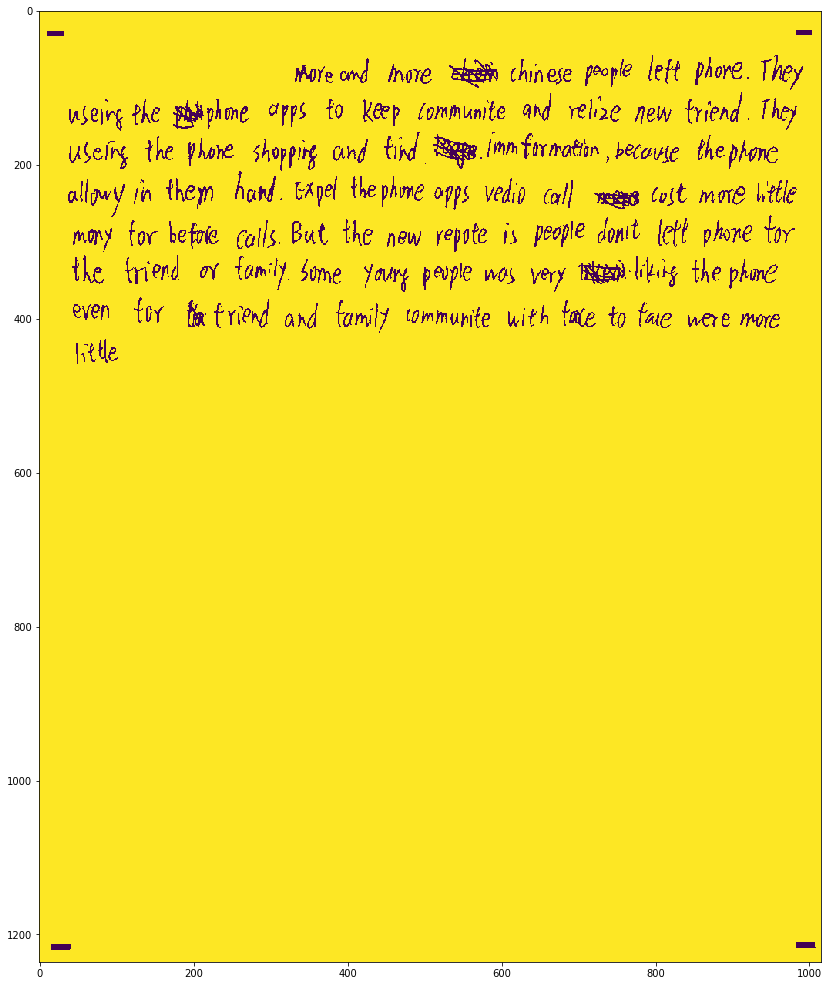

In [4]:
# image = loadImage('Test-data/050200074.jpg');
image = loadImage('../Dataset/800000430.jpg');
(h, w) = np.shape(image);
_, image = cv.threshold(image,0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)
plt.imshow(image);

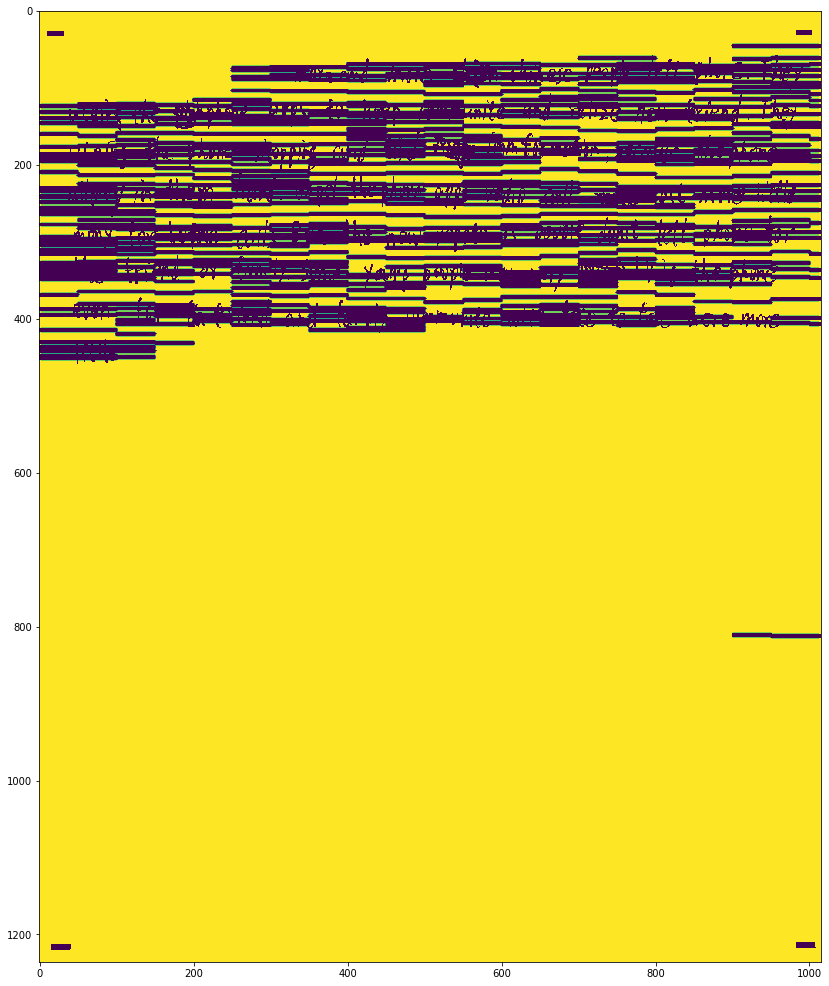

In [5]:
width = int (0.05 * w);
(h, w) = np.shape(image);
strips = (int (w/width) + (1 if w%width != 0 else 0));
M = 1;

wt = getWeights(M);
pp = [];
for i in range(strips):
    pp.append(projectionProfile(image, width, i));

delta = getdelta(image, width, strips, pp);
SPR = [];
for i in range(strips):
    SPR.append(getSPR(image, M, i, delta, wt, pp, strips));
    
dSPR = [];
CCheight = int (getCCHeight(image) / 2);
for i in range(strips):
    dSPR.append(getdiffSPR(SPR[i], image, CCheight));
showLine(image, dSPR, strips, width);

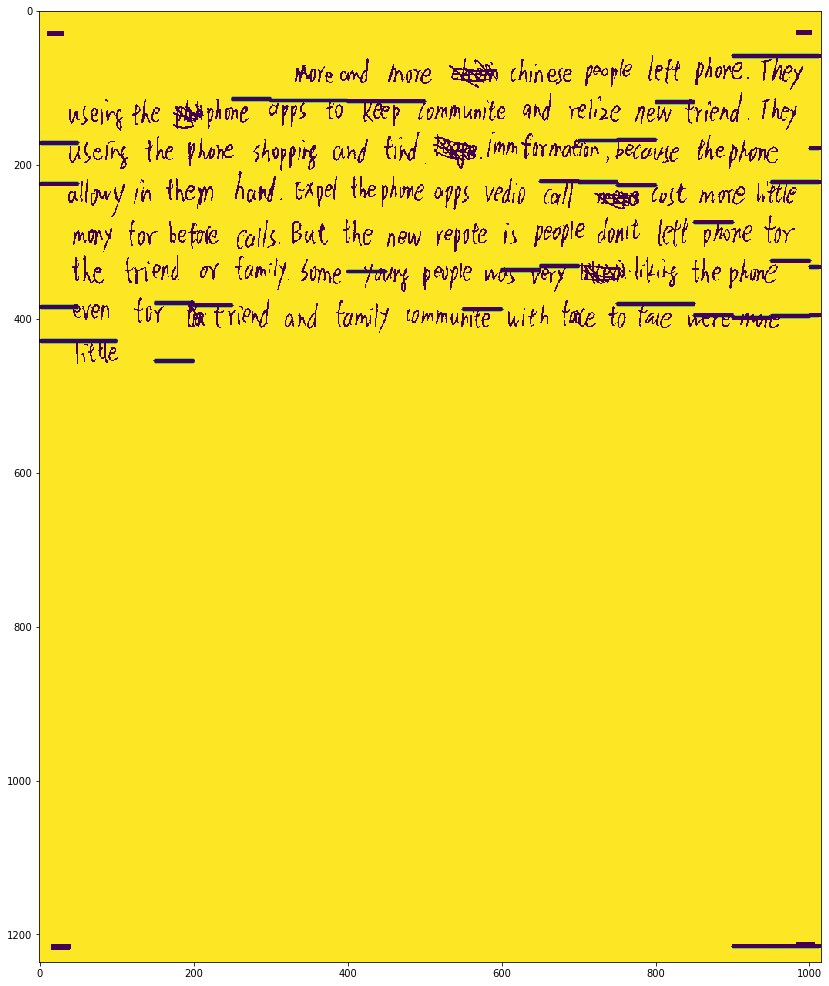

In [6]:
nRegions = applyViterbi(dSPR, strips, pp, width, CCheight, w)

pRegions = [];
for regionsStrip in nRegions:
    pRegionsStrip = [];
    tempRegion = [];
    gap = False
    for region in regionsStrip:
        if region[2] == 0:
            if gap:
                tempRegion[1] += region[1]
            else:
                if tempRegion != []:
                    pRegionsStrip.append(region[0] + int (region[1] / 2));
                tempRegion = region;
                gap = True;
        else:
            gap = False;
    pRegions.append (pRegionsStrip);
showProcessedRegions(image, pRegions, width, w);

In [7]:
lines = 0;
associateN = np.ones((h)) * -1;
for i in range(len (pRegions)):
    regionsStrip = pRegions[i];
    index = 0;
    
    if delta[i] == 0:
        continue;
    if i + 1 < len (pRegions):
        regionsStripN = pRegions[i + 1];
    else:
        regionsStripN = -1;
    
    associateT = np.copy(associateN);
    associateN = np.ones((h)) * -1;
    for j in range(len(regionsStrip)):
        region = regionsStrip[j];
        if associateT[j] != 1:
            lines += 1;
        if regionsStripN == -1:
            if associateT[j] == 0:
                print ("Find lines in prev zones")
            continue;
        
        while index + 1 < len(regionsStripN) and abs(regionsStrip[j] - regionsStripN[index]) > abs(regionsStrip[j] - regionsStripN[index + 1]):
            index += 1;
        
        if associateN[index] == 1:
            regionsStripN = performMultiAssociation(regionsStrip, j, regionsStripN, index, SPR[i + 1]);
            associateN[index + 1] = 1;
            index += 1;
        else:
            associateN[index] = 1;

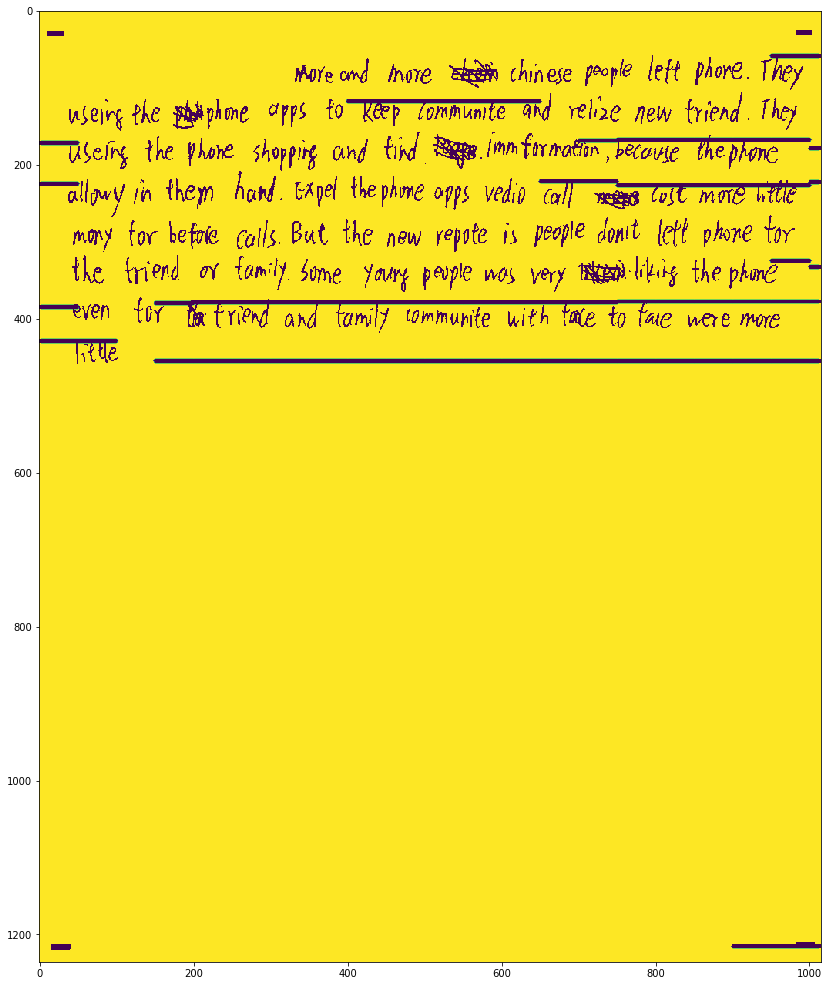

In [8]:
showProcessedRegions(image, pRegions, width, w);

In [9]:
lines

8